In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import codecs
import errno
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torchvision.models as models
import time
import copy
from tqdm import tqdm
#from skimage import io, transform
import cv2
import xml.etree.ElementTree as ET
from datetime import datetime

plt.ion()   # interactive mode

In [2]:
class DatasetPrepare():
    
    def __init__(self, root_dir, max_days_to_match=2, max_days_diff_for_neg=2):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.max_days_to_match = max_days_to_match
        self.max_days_diff_for_neg = max_days_diff_for_neg
        self.image_list = []
        self.leaf_pair_match_data = []
        self.training_data = []
        self.validation_data = []
        plant_leaves_dic = {}
        
        # plant_id(experiment+chamber+plant), leaf_id, timestamp, annotation file(.xml), image index
        
        leaf_instance_list = []
        img_idx = 0
        for dirpath, dirs, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.xml') and file[0] != '.': #ignore hidden files
                    anno_file_path = dirpath + '/' + file
                    str_list = anno_file_path.split('/')
                    plant_image_id = str_list[-1].split('_')[1]
                    chamber_id = str_list[-3]
                    experiment_id = str_list[-4]
                    unique_plant_id = experiment_id + '-' + chamber_id + '-plant_' + plant_image_id
                    # str_list[-2] folder name
                    ymdhm = str_list[-2].split('_')[1:6] #year,month,day,hour,minute
                    ymdhm = [int(x) for x in ymdhm]
                    # folder timestamp
                    timestamp = datetime(ymdhm[0],ymdhm[1],ymdhm[2],ymdhm[3],ymdhm[4])
                    tree = ET.parse(anno_file_path)
                    root = tree.getroot()
                    # this is a set, there could be multiple polygons for a leaf
                    labeled_leaves_in_an_image = {name.text for name in root.findall('./object/name')}
                    self.image_list.append(cv2.imread(os.path.splitext(anno_file_path)[0]+".jpg"))
                    
                    if unique_plant_id not in plant_leaves_dic:
                        plant_leaves_dic[unique_plant_id] = []
                    
                    # leaf_id e.g. "corn-plant_2-leaf_6"
                    for leaf_id in labeled_leaves_in_an_image:
                        plant_leaves_dic[unique_plant_id].append([unique_plant_id, leaf_id, timestamp, anno_file_path, img_idx])
                        
#                     for leaf_id in labeled_leaves_in_an_image:
#                         leaf_instance_list.append([unique_plant_id, leaf_id, timestamp, anno_file_path, img_idx])
                        
                    img_idx += 1
                    
        
        train2val_ratio = 4.
        
        for plant_id, leaves in plant_leaves_dic.items():
            
            pos_examples_per_plant, neg_examples_per_plant = [], []
            
            for leaf1 in leaves:
                for leaf2 in leaves:
                     # check timestamp difference   
                    time_delta_days = abs((leaf1[2]-leaf2[2]).total_seconds()/3600./24.)
                    
                    if time_delta_days > 0.001 and time_delta_days < max_days_to_match + 0.5:
                        match = 1 if leaf1[1] == leaf2[1] else 0
                        if match == 1:
                            pos_examples_per_plant.append([leaf1, leaf2, match])
                        elif time_delta_days <= max_days_diff_for_neg + 0.5:
                            neg_examples_per_plant.append([leaf1, leaf2, match])
            
             #negative examples should be more than positive examples
             #duplicate positive examples to match the number of negative examples
            neg_size = len(neg_examples_per_plant)
            pos_size = len(pos_examples_per_plant)
            diff = neg_size-pos_size
            pos_examples_per_plant.extend(random.choices(pos_examples_per_plant, k=diff))
            
            #print(neg_size)
            
            if train2val_ratio < 4.:
                self.training_data.extend(neg_examples_per_plant)
                self.training_data.extend(pos_examples_per_plant)
            else:
                self.validation_data.extend(neg_examples_per_plant)
                self.validation_data.extend(pos_examples_per_plant)
            
            train2val_ratio = float(len(self.training_data))/float(len(self.validation_data))

            #print(train2val_ratio)
        print('train size: ',len(self.training_data),' val size: ',len(self.validation_data), ' ratio: ',train2val_ratio)
        
        #**********************
#         #sort by unique plant id
#         leaf_instance_list.sort(key = lambda x:x[0])
        
#         pos_data, neg_data = [], []
  
#         for leaf1 in leaf_instance_list:
#             for leaf2 in leaf_instance_list:
#                 #check timestamp difference   
#                 #time_delta = leaf1[2]-leaf2[2]
#                 time_delta_days = abs((leaf1[2]-leaf2[2]).seconds/3600./24.)
                
#                 if leaf1[0] == leaf2[0] and time_delta_days <= max_days_to_match + 0.5: 
#                     match = 1 if leaf1[1] == leaf2[1] else 0
#                     #doublecheck this days_diff_for_neg
#                     #days_diff_for_neg = abs(int(leaf1[1].split('-')[2][5:])-int(leaf2[1].split('-')[2][5:]))
#                     if match == 1:
#                         pos_data.append([leaf1, leaf2, match])
#                     elif time_delta_days <= self.max_days_diff_for_neg + 0.5:
#                         neg_data.append([leaf1, leaf2, match])
        
#         self.leaf_pair_match_data.extend(neg_data)
#         self.leaf_pair_match_data.extend(pos_data)
#         pos_cnt = len(pos_data)
        
#         #balance data, add more positive data
#         self.leaf_pair_match_data.extend(random.choices(pos_data, k=len(neg_data) - pos_cnt))

#         print('pos_cnt: ',len(pos_data), '  neg_cnt:', len(neg_data))

#         random.shuffle(self.leaf_pair_match_data)

#         self.leaf_pair_match_data.sort(key = lambda x:x[2])# sort by match label

#         #split data 80/20
#         for i, leaf_pair_match in enumerate(self.leaf_pair_match_data):
#             if i%5 != 1:
#                 self.training_data.append(leaf_pair_match)
#             else:
#                 self.validation_data.append(leaf_pair_match)
            
    def getTrainingDataset(self):
        return self.trainning_dataset
    
    def getValidationDataset(self):
        return self.validation_dataset

data_root_dir = '/home/lietang/Documents/Leaf_Matcher/Enviratron_Corn_Leaf_Data'
dataset_prepare = DatasetPrepare(root_dir=data_root_dir, max_days_to_match=1., max_days_diff_for_neg=1.)

train size:  10848  val size:  3596  ratio:  3.0166852057842046


In [3]:
data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        #transforms.RandomSizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class EnviratronCornLeafDataset(Dataset):
    """Enviratron Corn Leaf dataset."""

    def __init__(self, dataset_prepare, transform, mode='train'):
        
        if mode == 'train':
            self.data = dataset_prepare.training_data
        elif mode == 'val':
            self.data = dataset_prepare.validation_data
        else:
            print('wrong mode')
            
        self.image_list = dataset_prepare.image_list
        self.transform = transform
                       
    def getPolygons(self, leaf_id, anno_xml_file):      
        tree = ET.parse(anno_xml_file)
        root = tree.getroot()
        leaf_polygons = []
        plant_polygons = []
        for obj in root.findall('./object'):

            polygon = obj.find('./polygon')
            xy_coordinates = [item.text for item in polygon.iter()]
            # remove the first element '\n    '
            xy_coordinates.pop(0)
            xy_coordinates = np.array(xy_coordinates).astype(np.int32)
            # 1d array to 2d array, -1 means infer the size from old array
            vertices = np.reshape(xy_coordinates, (-1,2))
            plant_polygons.append(vertices)

            if obj.find('./name').text == leaf_id:
                leaf_polygons.append(vertices)

        return leaf_polygons, plant_polygons
                
    def __len__(self):
        return len(self.data)
    
    def leafData2Patch(self, leaf, consider_plant=0, highlight_leaf=0):
        leaf_polygons, plant_polygons = self.getPolygons(leaf[1], leaf[3])
        #img_path = os.path.splitext(leaf1[3])[0]+".jpg"
        #img = cv2.imread(img_path)
        img = self.image_list[leaf[4]]
            
        # this will draw multiple polygons of the same plant 
        if highlight_leaf:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray3 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
            leaf_mask = np.zeros(img.shape, np.uint8)
            cv2.drawContours(leaf_mask, leaf_polygons, -1, [1,1,1], thickness=-1) #-1, all polygons;
            plant_mask = np.zeros(img.shape, np.uint8)            
            cv2.drawContours(plant_mask, plant_polygons, -1, [1,1,1], thickness=-1) #-1, all polygons;
            
#             new_img = (1-leaf_mask)*gray3+img*leaf_mask
#             img = new_img
            plant_without_leaf = plant_mask*img*(1-leaf_mask)
            img = plant_without_leaf + (255-leaf_mask*img)*leaf_mask
            
        # data augmentation, random rotation
        if consider_plant:
            vertices = np.concatenate(plant_polygons)
        else:
            vertices = np.concatenate(leaf_polygons)
            
        center = np.mean(vertices,0)
        rot = cv2.getRotationMatrix2D(tuple(center), random.randint(-15,15), 1.0)
        img_r = cv2.warpAffine(img, rot, img.shape[1::-1], borderMode=cv2.BORDER_REFLECT)
        vertices_r = vertices.dot(np.transpose(rot[0:2,0:2]))
        vertices_r[:,0] += np.ones(vertices_r.shape[0])*rot[0,2]
        vertices_r[:,1] += np.ones(vertices_r.shape[0])*rot[1,2]
        vertices_r = vertices_r.astype(np.int32)
    
        x,y,w,h = cv2.boundingRect(vertices_r)
        
        x = min(max(x, 0), img_r.shape[1])
        x_ = min(max(x+w, 0), img_r.shape[1])
        y = min(max(y, 0), img_r.shape[0])
        y_ = min(max(y+h, 0), img_r.shape[0])
        
        return img_r[y:y_,x:x_]
        

    def __getitem__(self, idx):
        
        leaf1, leaf2, match = self.data[idx]
        
        bb1 = self.leafData2Patch(leaf1)
        bb2 = self.leafData2Patch(leaf2)
        
        if self.transform:
            bb1 = self.transform(bb1)
            bb2 = self.transform(bb2)

        return bb1, bb2, match

image_datasets = {x: EnviratronCornLeafDataset(dataset_prepare, data_transform, x) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#print(len(image_datasets['train'].data),len(image_datasets['val'].data))
#image_datasets['train'].__getitem__(2)

In [4]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=0) for x in ['train', 'val']}

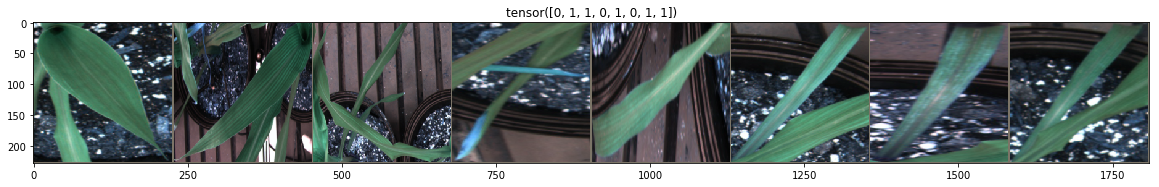

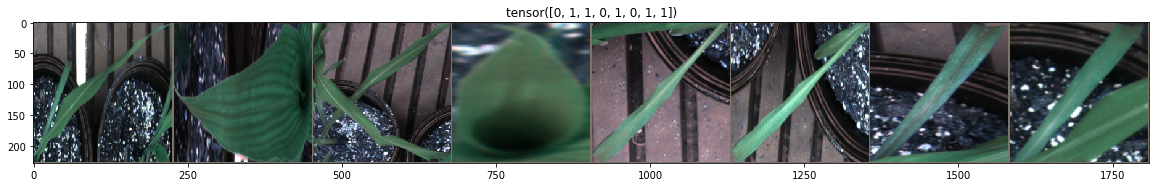

In [5]:
def imshow(inp,title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs1, inputs2, match_results = next(iter(dataloaders['val']))

# Make a grid from batch
out1 = torchvision.utils.make_grid(inputs1)
out2 = torchvision.utils.make_grid(inputs2)

imshow(out1, match_results)
imshow(out2, match_results)

In [6]:
print(models.resnet50())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [7]:
class LeafMatcherNet(nn.Module):
    def __init__(self, h1=1024, d=0.35):
        super(LeafMatcherNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.subnet = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool, resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4)
        for param in self.subnet.parameters():
            param.requires_grad = False
            
        #inp = 25088 #resnet 18
        inp = 100352 #resnet 50
        
        self.ap = nn.AdaptiveAvgPool2d((1,1))
        self.bn0 = nn.BatchNorm1d(inp*2, eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(d)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1, eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(d)
        self.fc2 = nn.Linear(h1, 2)
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(10, 12, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(12, 14, kernel_size=3),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(14 * 10 * 10, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 14 * 10 * 10)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
            
    def forward(self, x1, x2):
        # transform the input
        x1 = self.stn(x1)
        x2 = self.stn(x2)
                
        x1 = self.subnet(x1)
        x2 = self.subnet(x2)
        
        #print(x1.size())
        
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        #print(x1.size()) 
        
        x = torch.cat((x1, x2), 1)
        
        #print(x.size())
    
        x = self.bn0(x)
        #x = self.dropout0(x) 
        # Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift
        # suggest don't use dropout before batchnorm
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        #print(x)
        return x

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs1, inputs2, labels in dataloaders[phase]:
                inputs1 = inputs1.to(device)
                inputs2 = inputs2.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs1, inputs2)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs1.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
model_ft = LeafMatcherNet()
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)


Epoch 0/49
----------


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs1, inputs2, labels) in enumerate(dataloaders['val']):
            inputs1 = inputs1.to(device)
            inputs2 = inputs2.to(device)
            labels = labels.to(device)

            outputs = model(inputs1, inputs2)
            #_, preds = torch.max(outputs, 1)

            for j in range(inputs1.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, 2, 1)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(outputs[j]))
                imshow(inputs1.cpu().data[j])
                ax = plt.subplot(1, 2, 2)
                ax.axis('off')
                ax.set_title('GT: {}'.format(labels[j]))
                imshow(inputs2.cpu().data[j])
        
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
visualize_model(model_ft)